# Machine Learning in Julia, JuliaCon2020

A workshop introducing the machine learning toolbox
[MLJ](https://alan-turing-institute.github.io/MLJ.jl/stable/)

### Environment instantiation

The following loads a Julia environment, defined in Project.toml and
Manifest.toml files **which must be in the same directory as this
file**:

In [1]:
include(joinpath(@__DIR__, "setup.jl"))

 Activating environment at `~/Dropbox/Julia7/MLJ/MachineLearningInJulia2020/Project.toml`


If this is the notebook version of the tutorial, then it is
recommended that you clear all cell outputs before attempting the
tutorial.

## Contents

- [Part 1: Data Representation](#part-1-data-representation)
- [Part 2: Selecting, Training and Evaluating Models](#part-2-selecting-training-and-evaluating-models)

## Part 1: Data Representation

> **Goals:**
> 1. Learn how MLJ specifies it's data requirements using "scientific" types
> 2. Understand the options for representing tabular data
> 3. Learn how to inspect and fix the representation of data to meet MLJ requirements

### Scientific types

To help you focus on the intended *purpose* or *interpretation* of
data, MLJ models specify data requirements using *scientific types*,
instead of machine types. An example of a scientific type is
`OrderedFactor`. The other basic "scalar" scientific types are
illustrated below:

![](assets/scitypes.png)

A scientific type is an ordinary Julia type (so it can be used for
method dispatch, for example) but it usually has no instances. The
`scitype` function is used to articulate MLJ's convention about how
different machine types will be interpreted by MLJ models:

In [2]:
using MLJ
scitype(3.141)

Continuous

In [3]:
time = [2.3, 4.5, 4.2, 1.8, 7.1]
scitype(time)

AbstractArray{Continuous,1}

To fix data which MLJ is interpreting incorrectly, we use the
`coerce` method:

In [4]:
height = [185, 153, 163, 114, 180]
scitype(height)

AbstractArray{Count,1}

In [5]:
height = coerce(height, Continuous)

5-element Array{Float64,1}:
 185.0
 153.0
 163.0
 114.0
 180.0

Here's an example of data we would want interpreted as
`OrderedFactor` but isn't:

In [6]:
exam_mark = ["rotten", "great", "bla",  missing, "great"]
scitype(exam_mark)

AbstractArray{Union{Missing, Textual},1}

In [7]:
exam_mark = coerce(exam_mark, OrderedFactor)

┌ Info: Trying to coerce from `Union{Missing, String}` to `OrderedFactor`.
│ Coerced to `Union{Missing,OrderedFactor}` instead.
└ @ MLJScientificTypes /Users/anthony/.julia/packages/MLJScientificTypes/wqfgN/src/convention/coerce.jl:126


5-element CategoricalArray{Union{Missing, String},1,UInt32}:
 "rotten"
 "great"
 "bla"
 missing
 "great"

In [8]:
levels(exam_mark)

3-element Array{String,1}:
 "bla"
 "great"
 "rotten"

Use `levels!` to put the classes in the right order:

In [9]:
levels!(exam_mark, ["rotten", "bla", "great"])
exam_mark[1] < exam_mark[2]

true

When subsampling, no levels are not lost:

In [10]:
levels(exam_mark[1:2])

3-element Array{String,1}:
 "rotten"
 "bla"
 "great"

**Note on binary data.** There is no separate scientific type for binary
data. Binary data is `OrderedFactor{2}` if it has an intrinsic
"true" class (eg, "pass"/"fail") and `Multiclass{2}` otherwise (eg,
"male"/"female").

### Two-dimensional data

Whenever it makes sense, MLJ Models generally expect two-dimensional
data to be *tabular*. All the tabular formats implementing the
[Tables.jl API](https://juliadata.github.io/Tables.jl/stable/) (see
this
[list](https://github.com/JuliaData/Tables.jl/blob/master/INTEGRATIONS.md))
have a scientific type of `Table` and can be used with such models.

The simplest example of a table is a the julia native *column
table*, which is just a named tuple of equal-length vectors:

In [11]:
column_table = (h=height, e=exam_mark, t=time)

(h = [185.0, 153.0, 163.0, 114.0, 180.0],
 e = Union{Missing, CategoricalValue{String,UInt32}}["rotten", "great", "bla", missing, "great"],
 t = [2.3, 4.5, 4.2, 1.8, 7.1],)

In [12]:
scitype(column_table)

Table{Union{AbstractArray{Union{Missing, OrderedFactor{3}},1}, AbstractArray{Continuous,1}}}

Notice the `Table{K}` type parameter `K` encodes the scientific
types of the columns. (This is useful when comparing table scitypes
with `<:`). To inspect the individual column scitypes, we use the
`schema` method instead:

In [13]:
schema(column_table)

┌─────────┬─────────────────────────────────────────────────┬──────────────────────────────────┐
│ _.names │ _.types                                         │ _.scitypes                       │
├─────────┼─────────────────────────────────────────────────┼──────────────────────────────────┤
│ h       │ Float64                                         │ Continuous                       │
│ e       │ Union{Missing, CategoricalValue{String,UInt32}} │ Union{Missing, OrderedFactor{3}} │
│ t       │ Float64                                         │ Continuous                       │
└─────────┴─────────────────────────────────────────────────┴──────────────────────────────────┘
_.nrows = 5


Here are four other examples of tables:

In [14]:
row_table = [(a=1, b=3.4),
             (a=2, b=4.5),
             (a=3, b=5.6)]
schema(row_table)

┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ a       │ Int64   │ Count      │
│ b       │ Float64 │ Continuous │
└─────────┴─────────┴────────────┘
_.nrows = 3


In [15]:
import DataFrames
df = DataFrames.DataFrame(column_table)

,h,e,t
,Float64,Cat…?,Float64
1,185.0,rotten,2.3
2,153.0,great,4.5
3,163.0,bla,4.2
4,114.0,missing,1.8
5,180.0,great,7.1


In [16]:
schema(df)

┌─────────┬─────────────────────────────────────────────────┬──────────────────────────────────┐
│ _.names │ _.types                                         │ _.scitypes                       │
├─────────┼─────────────────────────────────────────────────┼──────────────────────────────────┤
│ h       │ Float64                                         │ Continuous                       │
│ e       │ Union{Missing, CategoricalValue{String,UInt32}} │ Union{Missing, OrderedFactor{3}} │
│ t       │ Float64                                         │ Continuous                       │
└─────────┴─────────────────────────────────────────────────┴──────────────────────────────────┘
_.nrows = 5


In [17]:
using CSV
file = CSV.File(joinpath(DIR, "data", "horse.csv"));
schema(file) # (triggers a file read)

┌─────────────────────────┬─────────┬────────────┐
│ _.names                 │ _.types │ _.scitypes │
├─────────────────────────┼─────────┼────────────┤
│ surgery                 │ Int64   │ Count      │
│ age                     │ Int64   │ Count      │
│ rectal_temperature      │ Float64 │ Continuous │
│ pulse                   │ Int64   │ Count      │
│ respiratory_rate        │ Int64   │ Count      │
│ temperature_extremities │ Int64   │ Count      │
│ mucous_membranes        │ Int64   │ Count      │
│ capillary_refill_time   │ Int64   │ Count      │
│ pain                    │ Int64   │ Count      │
│ peristalsis             │ Int64   │ Count      │
│ abdominal_distension    │ Int64   │ Count      │
│ packed_cell_volume      │ Float64 │ Continuous │
│ total_protein           │ Float64 │ Continuous │
│ outcome                 │ Int64   │ Count      │
│ surgical_lesion         │ Int64   │ Count      │
│ cp_data                 │ Int64   │ Count      │
└─────────────────────────┴────

Most MLJ models do not accept matrix in lieu of a table, but you can
wrap a matrix as a table:

In [18]:
matrix_table = MLJ.table(rand(2,3))
schema(matrix_table)

┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ x1      │ Float64 │ Continuous │
│ x2      │ Float64 │ Continuous │
│ x3      │ Float64 │ Continuous │
└─────────┴─────────┴────────────┘
_.nrows = 2


Under the hood many algorithms convert tabular data to matrices. If
your table is a wrapped matrix like the above, then the compiler
will generally collapse the conversions to a no-op.

**Manipulating tabular data.** In this workshop we assume
familiarity with some kind of tabular data container (although it is
possible, in principle, to carry out the exercises without this.)
For a quick start introduction to `DataFrames`, see [this
tutorial](https://alan-turing-institute.github.io/DataScienceTutorials.jl/data/dataframe/)

### Fixing scientific types in tabular data

To show how we can correct the scientific types of data in tables,
we introduce a cleaned up version of the UCI Horse Colic Data Set
(the cleaning workflow is described
[here](https://alan-turing-institute.github.io/DataScienceTutorials.jl/end-to-end/horse/#dealing_with_missing_values))

In [19]:
using CSV
file = CSV.File(joinpath(DIR, "data", "horse.csv"));
horse = DataFrames.DataFrame(file); # convert to data frame without copying columns
first(horse, 4)

,surgery,age,rectal_temperature,pulse,respiratory_rate,temperature_extremities,mucous_membranes
,Int64,Int64,Float64,Int64,Int64,Int64,Int64
1,2,1,38.5,66,66,3,1
2,1,1,39.2,88,88,3,4
3,2,1,38.3,40,40,1,3
4,1,9,39.1,164,164,4,6


From [the UCI
docs](http://archive.ics.uci.edu/ml/datasets/Horse+Colic) we can
surmise how each variable ought to be interpreted (a step in our
workflow that cannot reliably be left to the computer):

variable                    | scientific type (interpretation)
----------------------------|-----------------------------------
`:surgery`                  | Multiclass
`:age`                      | Multiclass
`:rectal_temperature`       | Continuous
`:pulse`                    | Continuous
`:respiratory_rate`         | Continuous
`:temperature_extremities`  | OrderedFactor
`:mucous_membranes`         | Multiclass
`:capillary_refill_time`    | Multiclass
`:pain`                     | OrderedFactor
`:peristalsis`              | OrderedFactor
`:abdominal_distension`     | OrderedFactor
`:packed_cell_volume`       | Continuous
`:total_protein`            | Continuous
`:outcome`                  | Multiclass
`:surgical_lesion`          | OrderedFactor
`:cp_data`                  | Multiclass

Let's see how MLJ will actually interpret the data, as it is
currently encoded:

In [20]:
schema(horse)

┌─────────────────────────┬─────────┬────────────┐
│ _.names                 │ _.types │ _.scitypes │
├─────────────────────────┼─────────┼────────────┤
│ surgery                 │ Int64   │ Count      │
│ age                     │ Int64   │ Count      │
│ rectal_temperature      │ Float64 │ Continuous │
│ pulse                   │ Int64   │ Count      │
│ respiratory_rate        │ Int64   │ Count      │
│ temperature_extremities │ Int64   │ Count      │
│ mucous_membranes        │ Int64   │ Count      │
│ capillary_refill_time   │ Int64   │ Count      │
│ pain                    │ Int64   │ Count      │
│ peristalsis             │ Int64   │ Count      │
│ abdominal_distension    │ Int64   │ Count      │
│ packed_cell_volume      │ Float64 │ Continuous │
│ total_protein           │ Float64 │ Continuous │
│ outcome                 │ Int64   │ Count      │
│ surgical_lesion         │ Int64   │ Count      │
│ cp_data                 │ Int64   │ Count      │
└─────────────────────────┴────

As a first correction step, we can get MLJ to "guess" the
appropriate fix, using the `autotype` method:

In [21]:
autotype(horse)

Dict{Symbol,Type} with 11 entries:
  :abdominal_distension    => OrderedFactor
  :pain                    => OrderedFactor
  :surgery                 => OrderedFactor
  :mucous_membranes        => OrderedFactor
  :surgical_lesion         => OrderedFactor
  :outcome                 => OrderedFactor
  :capillary_refill_time   => OrderedFactor
  :age                     => OrderedFactor
  :temperature_extremities => OrderedFactor
  :peristalsis             => OrderedFactor
  :cp_data                 => OrderedFactor

Okay, this is not perfect, but a step in the right direction, which
we implement like this:

In [22]:
coerce!(horse, autotype(horse));
schema(horse)

┌─────────────────────────┬────────────────────────────────┬──────────────────┐
│ _.names                 │ _.types                        │ _.scitypes       │
├─────────────────────────┼────────────────────────────────┼──────────────────┤
│ surgery                 │ CategoricalValue{Int64,UInt32} │ OrderedFactor{2} │
│ age                     │ CategoricalValue{Int64,UInt32} │ OrderedFactor{2} │
│ rectal_temperature      │ Float64                        │ Continuous       │
│ pulse                   │ Int64                          │ Count            │
│ respiratory_rate        │ Int64                          │ Count            │
│ temperature_extremities │ CategoricalValue{Int64,UInt32} │ OrderedFactor{4} │
│ mucous_membranes        │ CategoricalValue{Int64,UInt32} │ OrderedFactor{6} │
│ capillary_refill_time   │ CategoricalValue{Int64,UInt32} │ OrderedFactor{3} │
│ pain                    │ CategoricalValue{Int64,UInt32} │ OrderedFactor{5} │
│ peristalsis             │ CategoricalV

All remaining `Count` data should be `Continuous`:

In [23]:
coerce!(horse, Count => Continuous);
schema(horse)

┌─────────────────────────┬────────────────────────────────┬──────────────────┐
│ _.names                 │ _.types                        │ _.scitypes       │
├─────────────────────────┼────────────────────────────────┼──────────────────┤
│ surgery                 │ CategoricalValue{Int64,UInt32} │ OrderedFactor{2} │
│ age                     │ CategoricalValue{Int64,UInt32} │ OrderedFactor{2} │
│ rectal_temperature      │ Float64                        │ Continuous       │
│ pulse                   │ Float64                        │ Continuous       │
│ respiratory_rate        │ Float64                        │ Continuous       │
│ temperature_extremities │ CategoricalValue{Int64,UInt32} │ OrderedFactor{4} │
│ mucous_membranes        │ CategoricalValue{Int64,UInt32} │ OrderedFactor{6} │
│ capillary_refill_time   │ CategoricalValue{Int64,UInt32} │ OrderedFactor{3} │
│ pain                    │ CategoricalValue{Int64,UInt32} │ OrderedFactor{5} │
│ peristalsis             │ CategoricalV

We'll correct the remaining truant entries manually:

In [24]:
coerce!(horse,
        :surgery               => Multiclass,
        :age                   => Multiclass,
        :mucous_membranes      => Multiclass,
        :capillary_refill_time => Multiclass,
        :outcome               => Multiclass,
        :cp_data               => Multiclass);
schema(horse)

┌─────────────────────────┬────────────────────────────────┬──────────────────┐
│ _.names                 │ _.types                        │ _.scitypes       │
├─────────────────────────┼────────────────────────────────┼──────────────────┤
│ surgery                 │ CategoricalValue{Int64,UInt32} │ Multiclass{2}    │
│ age                     │ CategoricalValue{Int64,UInt32} │ Multiclass{2}    │
│ rectal_temperature      │ Float64                        │ Continuous       │
│ pulse                   │ Float64                        │ Continuous       │
│ respiratory_rate        │ Float64                        │ Continuous       │
│ temperature_extremities │ CategoricalValue{Int64,UInt32} │ OrderedFactor{4} │
│ mucous_membranes        │ CategoricalValue{Int64,UInt32} │ Multiclass{6}    │
│ capillary_refill_time   │ CategoricalValue{Int64,UInt32} │ Multiclass{3}    │
│ pain                    │ CategoricalValue{Int64,UInt32} │ OrderedFactor{5} │
│ peristalsis             │ CategoricalV

### Resources for Part 1

- From the MLJ manual:
   - [A preview of data type specification in
  MLJ](https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/#A-preview-of-data-type-specification-in-MLJ-1)
   - [Data containers and scientific types](https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/#Data-containers-and-scientific-types-1)
   - [Working with Categorical Data](https://alan-turing-institute.github.io/MLJ.jl/dev/working_with_categorical_data/)
- [Summary](https://alan-turing-institute.github.io/MLJScientificTypes.jl/dev/#Summary-of-the-MLJ-convention-1) of the MLJ convention for representing scientific types
- [MLJScientificTypes.jl](https://alan-turing-institute.github.io/MLJScientificTypes.jl/dev/)
- From Data Science Tutorials:
    - [Data interpretation: Scientific Types](https://alan-turing-institute.github.io/DataScienceTutorials.jl/data/scitype/)
    - [Horse colic data](https://alan-turing-institute.github.io/DataScienceTutorials.jl/end-to-end/horse/)
- [UCI Horse Colic Data Set](http://archive.ics.uci.edu/ml/datasets/Horse+Colic)

### Exercises for Part 1

#### Exercise 1

Try to guess how each code snippet below will evaluate:

In [25]:
scitype(42)

Count

In [26]:
questions = ["who", "why", "what", "when"]
scitype(questions)

AbstractArray{Textual,1}

In [27]:
elscitype(questions)

Textual

In [28]:
t = (3.141, 42, "how")
scitype(t)

Tuple{Continuous,Count,Textual}

In [29]:
A = rand(2, 3)

2×3 Array{Float64,2}:
 0.125186  0.613498  0.043456
 0.275349  0.569883  0.653459

-

In [30]:
scitype(A)

AbstractArray{Continuous,2}

In [31]:
elscitype(A)

Continuous

In [32]:
using SparseArrays
Asparse = sparse(A)

2×3 SparseMatrixCSC{Float64,Int64} with 6 stored entries:
  [1, 1]  =  0.125186
  [2, 1]  =  0.275349
  [1, 2]  =  0.613498
  [2, 2]  =  0.569883
  [1, 3]  =  0.043456
  [2, 3]  =  0.653459

In [33]:
scitype(Asparse)

AbstractArray{Continuous,2}

In [34]:
using CategoricalArrays
C1 = categorical(A)

2×3 CategoricalArray{Float64,2,UInt32}:
 0.12518583927344973  0.6134977059280065  0.04345602836867024
 0.27534934198023686  0.5698825589352163  0.6534585348686746

In [35]:
scitype(C1)

AbstractArray{Multiclass{6},2}

In [36]:
elscitype(C1)

Multiclass{6}

In [37]:
C2 = categorical(A, ordered=true)
scitype(C2)

AbstractArray{OrderedFactor{6},2}

In [38]:
v = [1, 2, missing, 4]
scitype(v)

AbstractArray{Union{Missing, Count},1}

In [39]:
elscitype(v)

Union{Missing, Count}

In [40]:
scitype(v[1:2])

AbstractArray{Union{Missing, Count},1}

Can you guess at the general behaviour of
`scitype` with respect to tuples, abstract arrays and missing
values? The answers are
[here](https://github.com/alan-turing-institute/ScientificTypes.jl#2-the-scitype-and-scitype-methods)
(ignore "Property 1").

#### Exercise 2

Coerce the following vector to make MLJ recognize it as a vector of
ordered factors (with an appropriate ordering):

In [41]:
quality = ["good", "poor", "poor", "excellent", missing, "good", "excellent"]

7-element Array{Union{Missing, String},1}:
 "good"
 "poor"
 "poor"
 "excellent"
 missing
 "good"
 "excellent"

#### Exercise 3 (fixing scitypes in a table)

Fix the scitypes for the [House Prices in King
County](https://mlr3gallery.mlr-org.com/posts/2020-01-30-house-prices-in-king-county/)
dataset:

In [42]:
file = CSV.File(joinpath(DIR, "data", "house.csv"));
house = DataFrames.DataFrame(file); # convert to data frame without copying columns
first(house, 4)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition
,Float64,Int64,Float64,Int64,Int64,Float64,Int64,Int64,Int64
1,221900.0,3,1.0,1180,5650,1.0,0,0,3
2,538000.0,3,2.25,2570,7242,2.0,0,0,3
3,180000.0,2,1.0,770,10000,1.0,0,0,3
4,604000.0,4,3.0,1960,5000,1.0,0,0,5


(Two features in the original data set have been deemed uninformative
and dropped, namely `:id` and `:date`. The original feature
`:yr_renovated` has been replaced by the `Bool` feature `is_renovated`.)

## Part 2: Selecting, Training and Evaluating Models

> **Goals:**
> 1. Search MLJ's database of model metadata to identify model candidates for a supervised learning task.
> 2. Evaluate the performance of a model on a holdout set using basic `fit!`/`predict` workflow.
> 3. Evaluate performance using other resampling strategies, such as cross-validation, in one line, using `evaluate!`
> 4. Plot a "learning curve", to inspect performance as a function of some model hyper-parameter, such as an iteration parameter

The "Hello World!" of machine learning is to classify Fisher's
famous iris data set. This time, we'll grab the data from
[OpenML](https://www.openml.org):

In [43]:
iris = OpenML.load(61); # a row table
iris = DataFrames.DataFrame(iris);
first(iris, 4)

,sepallength,sepalwidth,petallength,petalwidth,class
,Float64,Float64,Float64,Float64,SubStri…
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa


**Goal.** To build and evaluate models for predicting the
`:class` variable, given the four remaining measurement variables.

### Step 1. Inspect and fix scientific types

In [44]:
schema(iris)

┌─────────────┬───────────────────┬────────────┐
│ _.names     │ _.types           │ _.scitypes │
├─────────────┼───────────────────┼────────────┤
│ sepallength │ Float64           │ Continuous │
│ sepalwidth  │ Float64           │ Continuous │
│ petallength │ Float64           │ Continuous │
│ petalwidth  │ Float64           │ Continuous │
│ class       │ SubString{String} │ Textual    │
└─────────────┴───────────────────┴────────────┘
_.nrows = 150


In [45]:
coerce!(iris, :class => Multiclass);
schema(iris)

┌─────────────┬─────────────────────────────────┬───────────────┐
│ _.names     │ _.types                         │ _.scitypes    │
├─────────────┼─────────────────────────────────┼───────────────┤
│ sepallength │ Float64                         │ Continuous    │
│ sepalwidth  │ Float64                         │ Continuous    │
│ petallength │ Float64                         │ Continuous    │
│ petalwidth  │ Float64                         │ Continuous    │
│ class       │ CategoricalValue{String,UInt32} │ Multiclass{3} │
└─────────────┴─────────────────────────────────┴───────────────┘
_.nrows = 150


### Step 2. Split data into input and target parts

Here's how we split the data into target and input features, which
is needed for MLJ supervised models. We randomize the data at the
same time:

In [46]:
y, X = unpack(iris, ==(:class), name->true; rng=123);
scitype(y)

AbstractArray{Multiclass{3},1}

Do `?unpack` to learn more:

In [47]:
@doc unpack

```
t1, t2, ...., tk = unnpack(table, f1, f2, ... fk; wrap_singles=false)
```

Split any Tables.jl compatible `table` into smaller tables (or vectors) `t1, t2, ..., tk` by making selections *without replacement* from the column names defined by the filters `f1`, `f2`, ..., `fk`. A *filter* is any object `f` such that `f(name)` is `true` or `false` for each column `name::Symbol` of `table`.

Whenever a returned table contains a single column, it is converted to a vector unless `wrap_singles=true`.

Scientific type conversions can be optionally specified (note semicolon):

```
unpack(table, t...; wrap_singles=false, col1=>scitype1, col2=>scitype2, ... )
```

### Example

```
julia> table = DataFrame(x=[1,2], y=['a', 'b'], z=[10.0, 20.0], w=[:A, :B])
julia> Z, XY = unpack(table, ==(:z), !=(:w);
               :x=>Continuous, :y=>Multiclass)
julia> XY
2×2 DataFrame
│ Row │ x       │ y            │
│     │ Float64 │ Categorical… │
├─────┼─────────┼──────────────┤
│ 1   │ 1.0     │ 'a'          │
│ 2   │ 2.0     │ 'b'          │

julia> Z
2-element Array{Float64,1}:
 10.0
 20.0
```


### On searching for a model

Here's how to see *all* models (not immediately useful):

In [48]:
kitchen_sink = models()

142-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = ARDRegressor, package_name = ScikitLearn, ... )
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostRegressor, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = AffinityPropagation, package_name = ScikitLearn, ... )
 (name = AgglomerativeClustering, package_name = ScikitLearn, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BaggingRegressor, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, 

Each entry contains metadata for a model whose defining code is not yet loaded:

In [49]:
meta = kitchen_sink[3]

AdaBoost ensemble regression.
→ based on [ScikitLearn](https://github.com/cstjean/ScikitLearn.jl).
→ do `@load AdaBoostRegressor pkg="ScikitLearn"` to use the model.
→ do `?AdaBoostRegressor` for documentation.
(name = "AdaBoostRegressor",
 package_name = "ScikitLearn",
 is_supervised = true,
 docstring = "AdaBoost ensemble regression.\n→ based on [ScikitLearn](https://github.com/cstjean/ScikitLearn.jl).\n→ do `@load AdaBoostRegressor pkg=\"ScikitLearn\"` to use the model.\n→ do `?AdaBoostRegressor` for documentation.",
 hyperparameter_ranges = (nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("Any", "Int64", "Float64", "String", "Any"),
 hyperparameters = (:base_estimator, :n_estimators, :learning_rate, :loss, :random_state),
 implemented_methods = [:clean!, :fit, :fitted_params, :predict],
 is_pure_julia = false,
 is_wrapper = true,
 load_path = "MLJScikitLearnInterface.AdaBoostRegressor",
 package_license = "BSD",
 package_url = "https://github.com/cstjean/Scik

In [50]:
targetscitype = meta.target_scitype

AbstractArray{Continuous,1}

In [51]:
scitype(y) <: targetscitype

false

So this model won't do. Let's  find all pure julia classifiers:

In [52]:
filt(meta) = AbstractVector{Finite} <: meta.target_scitype &&
        meta.is_pure_julia
models(filt)

16-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_name = MLJModels, ... )
 (name = EvoTreeClassifier, package_name = EvoTrees, ... )
 (name = GaussianNBClassifier, package_name = NaiveBayes, ... )
 (name = KNNClassifier, package_name = NearestNeighbors, ... )
 (name = LDA, package_name = 

Find all models with "Classifier" in `name` (or `docstring`):

In [53]:
models("Classifier")

39-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BernoulliNBClassifier, package_name = ScikitLearn, ... )
 (name = ComplementNBClassifier, package_name = ScikitLearn, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_name = MLJModels, ... )
 (name = DummyClassifier, package_name = ScikitLearn, ... )
 (name = EvoTreeClassifier, p

Find all (supervised) models that match my data!

In [54]:
models(matching(X, y))

42-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

### Step 3. Select and instantiate a model

In [55]:
model = @load NeuralNetworkClassifier

NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = Flux.Optimise.ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @803

In [56]:
info(model)

A neural network model for making probabilistic predictions of a `Mutliclass` or `OrderedFactor` target, given a table of `Continuous` features. 
→ based on [MLJFlux](https://github.com/alan-turing-institute/MLJFlux.jl).
→ do `@load NeuralNetworkClassifier pkg="MLJFlux"` to use the model.
→ do `?NeuralNetworkClassifier` for documentation.
(name = "NeuralNetworkClassifier",
 package_name = "MLJFlux",
 is_supervised = true,
 docstring = "A neural network model for making probabilistic predictions of a `Mutliclass` or `OrderedFactor` target, given a table of `Continuous` features. \n→ based on [MLJFlux](https://github.com/alan-turing-institute/MLJFlux.jl).\n→ do `@load NeuralNetworkClassifier pkg=\"MLJFlux\"` to use the model.\n→ do `?NeuralNetworkClassifier` for documentation.",
 hyperparameter_ranges = (nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("MLJFlux.Short", "typeof(NNlib.softmax)", "Flux.Optimise.ADAM", "typeof(Flux.cr

In MLJ a *model* is just a struct containing hyper-parameters, and
that's all. A model does not store *learned* parameters. Models are
mutable:

In [57]:
model.epochs = 12

12

And all models have a key-word constructor that works once `@load`
has been performed:

In [58]:
NeuralNetworkClassifier(epochs=12) == model

true

### On fitting, predicting, and inspecting models

In MLJ a model and training/validation data are typically bound
together in a machine:

In [59]:
mach = machine(model, X, y)

Machine{NeuralNetworkClassifier{Short,…}} @420 trained 0 times.
  args: 
    1:	Source @371 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @560 ⏎ `AbstractArray{Multiclass{3},1}`


A machine stores *learned* parameters, among other things. We'll
train this machine on 70% of the data and evaluate on a 30% holdout
set. Let's start by dividing all row indices into `train` and `test`
subsets:

In [60]:
train, test = partition(eachindex(y), 0.7)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  96, 97, 98, 99, 100, 101, 102, 103, 104, 105], [106, 107, 108, 109, 110, 111, 112, 113, 114, 115  …  141, 142, 143, 144, 145, 146, 147, 148, 149, 150])

In [61]:
fit!(mach, rows=train, verbosity=2)

┌ Info: Training Machine{NeuralNetworkClassifier{Short,…}} @420.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Loss is 1.099
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.089
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.082
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.071
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.062
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.051
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.043
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.032
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.021
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss

Machine{NeuralNetworkClassifier{Short,…}} @420 trained 1 time.
  args: 
    1:	Source @371 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @560 ⏎ `AbstractArray{Multiclass{3},1}`


After training, one can inspect the learned parameters:

In [62]:
fitted_params(mach)

(chain = Chain(Chain(Dense(4, 3, σ), Dropout(0.5), Dense(3, 3)), softmax),)

Everything else the user might be interested in is accessed from the
training *report*:

In [63]:
report(mach)

(training_losses = Any[1.09897f0, 1.0888609f0, 1.0816175f0, 1.0714965f0, 1.0621121f0, 1.0507153f0, 1.0427363f0, 1.0319378f0, 1.0205578f0, 1.0105981f0, 0.9939035f0, 0.9837377f0],)

Machines remember the last set of hyper-parameters used during fit,
which, in the case of iterative models, allows for a warm restart of
computations in the case that only the iteration parameter is
increased:

In [64]:
model.epochs = model.epochs + 4
fit!(mach, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…}} @420.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:318
┌ Info: Loss is 0.968
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.9538
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.9398
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.9224
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95


Machine{NeuralNetworkClassifier{Short,…}} @420 trained 2 times.
  args: 
    1:	Source @371 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @560 ⏎ `AbstractArray{Multiclass{3},1}`


By default (for this particular model) we can also increase
`:learning_rate` without triggering a cold restart:

In [65]:
model.epochs = model.epochs + 4
model.optimiser.eta = 10*model.optimiser.eta
fit!(mach, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…}} @420.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:318
┌ Info: Loss is 0.7768
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.7026
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.6233
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.5763
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95


Machine{NeuralNetworkClassifier{Short,…}} @420 trained 3 times.
  args: 
    1:	Source @371 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @560 ⏎ `AbstractArray{Multiclass{3},1}`


However, change any other parameter and training will restart from
scratch:

In [66]:
model.lambda = 0.001
fit!(mach, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…}} @420.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:318
┌ Info: Loss is 1.125
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.083
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.98
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.7402
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.6395
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.6151
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.5714
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.5341
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.5381
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info:

Machine{NeuralNetworkClassifier{Short,…}} @420 trained 4 times.
  args: 
    1:	Source @371 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @560 ⏎ `AbstractArray{Multiclass{3},1}`


Let's train silently for a total of 50 epochs, and look at a prediction:

In [67]:
model.epochs = 50
fit!(mach, rows=train)
yhat = predict(mach, X[test,:]); # or predict(mach, rows=test)
yhat[1]

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…}} @420.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:318
Optimising neural net:100%[=========================] Time: 0:00:00


UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.128, Iris-versicolor=>0.667, Iris-virginica=>0.204)

What's going on here?

In [68]:
info(model).prediction_type

:probabilistic

**Important**:
- In MLJ, a model that can predict probabilities (and not just point values) will do so by default. (These models have supertype `Proababilistic`, while point-estimate predictors have supertype `Deterministic`.)
- For most probabilistic predictors, the predicted object is a `Distributions.Distribution` object, supporting the `Distributions.jl` [API](https://juliastats.org/Distributions.jl/latest/extends/#Create-a-Distribution-1) for such objects. In particular, the methods `rand`,  `pdf`, `mode`, `median` and `mean` will apply, where appropriate.

So, to obtain the probability of "Iris-virginica" in the first test
prediction, we do

In [69]:
pdf(yhat[1], "Iris-virginica")

0.20434602f0

To get the most likely observation, we do

In [70]:
mode(yhat[1])

CategoricalValue{String,UInt32} "Iris-versicolor"

These can be broadcast over multiple predictions in the usual way:

In [71]:
broadcast(pdf, yhat[1:4], "Iris-versicolor")

4-element Array{Float32,1}:
 0.6672967
 0.5366527
 0.037599422
 0.38899064

In [72]:
mode.(yhat[1:4])

4-element CategoricalArray{String,1,UInt32}:
 "Iris-versicolor"
 "Iris-versicolor"
 "Iris-setosa"
 "Iris-virginica"

Or, alternatively, you can use the `predict_mode` operation instead
of `predict`:

In [73]:
predict_mode(mach, X[test,:])[1:4] # or predict_mode(mach, rows=test)[1:4]

4-element CategoricalArray{String,1,UInt32}:
 "Iris-versicolor"
 "Iris-versicolor"
 "Iris-setosa"
 "Iris-virginica"

For a more conventional matrix of probabilities you can do this:

In [74]:
L = levels(y)
pdf(yhat, L)[1:4, :]

4×3 Array{Float32,2}:
 0.128357     0.667297   0.204346
 0.0271739    0.536653   0.436173
 0.962401     0.0375994  1.58964f-10
 0.000447471  0.388991   0.610562

However, in a typical MLJ workflow, this is not as useful as you
might imagine. In particular, all probablistic performance measures
in MLJ expect distribution objects in their first slot:

In [75]:
cross_entropy(yhat, y[test]) |> mean

0.32660282f0

To apply a deterministic measure, we first need to obtain point-estimates:

In [76]:
misclassification_rate(mode.(yhat), y[test])

0.022222222222222223

We note in passing that there is also a search tool for measures
analogous to `models`:

In [77]:
measures(matching(y))

6-element Array{NamedTuple{(:name, :target_scitype, :supports_weights, :prediction_type, :orientation, :reports_each_observation, :aggregation, :is_feature_dependent, :docstring, :distribution_type),T} where T<:Tuple,1}:
 (name = accuracy, ...)
 (name = balanced_accuracy, ...)
 (name = cross_entropy, ...)
 (name = misclassification_rate, ...)
 (name = BrierScore{UnivariateFinite}, ...)
 (name = confusion_matrix, ...)

### Step 4. Evaluate the model performance

Naturally, MLJ provides boilerplate code for carrying out a model
evaluation with a lot less fuss. Let's repeat the performance
evaluation above and add an extra measure, `brier_score`:

In [78]:
evaluate!(mach, resampling=Holdout(fraction_train=0.7),
          measures=[cross_entropy, brier_score])

┌──────────────────────────────┬───────────────┬─────────────────┐
│ _.measure                    │ _.measurement │ _.per_fold      │
├──────────────────────────────┼───────────────┼─────────────────┤
│ cross_entropy                │ 0.327         │ Float32[0.327]  │
│ BrierScore{UnivariateFinite} │ -0.179        │ Float32[-0.179] │
└──────────────────────────────┴───────────────┴─────────────────┘
_.per_observation = [[[0.405, 0.622, ..., 0.0365]], [[-0.169, -0.406, ..., -0.00256]]]


Or applying cross-validation instead:

In [79]:
evaluate!(mach, resampling=CV(nfolds=6),
          measures=[cross_entropy, brier_score])

Evaluating over 6 folds: 100%[=========================] Time: 0:00:04


┌──────────────────────────────┬───────────────┬──────────────────────────────────────────────────────────┐
│ _.measure                    │ _.measurement │ _.per_fold                                               │
├──────────────────────────────┼───────────────┼──────────────────────────────────────────────────────────┤
│ cross_entropy                │ 0.334         │ Float32[0.364, 0.185, 0.35, 0.337, 0.481, 0.288]         │
│ BrierScore{UnivariateFinite} │ -0.179        │ Float32[-0.176, -0.0903, -0.183, -0.189, -0.282, -0.156] │
└──────────────────────────────┴───────────────┴──────────────────────────────────────────────────────────┘
_.per_observation = [[[0.24, 0.452, ..., 0.314], [0.000874, 0.436, ..., 0.000738], [0.235, 0.561, ..., 0.00945], [0.00825, 0.471, ..., 0.00898], [0.569, 0.474, ..., 0.752], [0.00326, 0.431, ..., 0.00265]], [[-0.0912, -0.225, ..., -0.121], [-1.55e-6, -0.214, ..., -1.07e-6], [-0.0877, -0.318, ..., -0.000177], [-0.000135, -0.258, ..., -0.00016], [-0.294

Or, Monte-Carlo cross-validation (cross-validation repeated
randomizied folds)

In [80]:
e = evaluate!(mach, resampling=CV(nfolds=6, rng=123),
                repeats=3,
              measures=[cross_entropy, brier_score])

Evaluating over 18 folds: 100%[=========================] Time: 0:00:13


┌──────────────────────────────┬───────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ _.measure                    │ _.measurement │ _.per_fold                                                                                                                                             │
├──────────────────────────────┼───────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ cross_entropy                │ 0.297         │ Float32[0.252, 0.354, 0.219, 0.293, 0.341, 0.32, 0.344, 0.278, 0.329, 0.267, 0.276, 0.295, 0.334, 0.268, 0.355, 0.226, 0.264, 0.325]                   │
│ BrierScore{UnivariateFinite} │ -0.15         │ Float32[-0.147, -0.161, -0.0801, -0.138, -0.189, -0.172, -0.2, -0.133, -0.179, -0.129, -0.144, -0.124, -0.182, -0.139, -0.182, -0.108, -0.128, 

One can access the following properties of the output `e` of an
evaluation: `measure`, `measurement`, `per_fold` (measurement for
each fold) and `per_observation` (measurement per observation, if
reported).

We finally note that you can restrict the rows of observations from
which train and test folds are drawn, by specifying `rows=...`. For
example, imagining the last 30% of target observations are `missing`
you might have a workflow like this:

In [81]:
train, test = partition(eachindex(y), 0.7)
mach = machine(model, X, y)
evaluate!(mach, resampling=CV(nfolds=6),
          measures=[cross_entropy, brier_score],
          rows=train)     # cv estimate, resampling from `train`
fit!(mach, rows=train)    # re-train using all of `train` observations
predict(mach, rows=test); # and predict missing targets

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/resampling.jl:336
Evaluating over 6 folds: 100%[=========================] Time: 0:00:03
┌ Info: Training Machine{NeuralNetworkClassifier{Short,…}} @914.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
Optimising neural net:100%[=========================] Time: 0:00:00


### On learning curves

Since our model is an iterative one, we might want to inspect the
out-of-sample performance as a function of the iteration
parameter. For this we can use the `learning_curve` function (which,
incidentally can be applied to any model hyper-parameter). This
starts by defining a one-dimensional range object for the parameter
(more on this when we discuss tuning in Part 4):

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @606.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Attempting to evaluate 22 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/oLVRR/src/tuned_models.jl:474
Evaluating over 22 metamodels: 100%[=========================] Time: 0:00:00


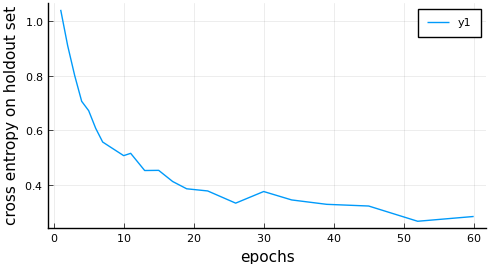

In [82]:
r = range(model, :epochs, lower=1, upper=60, scale=:log)
curve = learning_curve(mach,
                       range=r,
                       resampling=Holdout(fraction_train=0.7), # (default)
                       measure=cross_entropy)

using Plots
pyplot(size=(490,300))
plt=plot(curve.parameter_values, curve.measurements)
xlabel!(plt, "epochs")
ylabel!(plt, "cross entropy on holdout set")
plt

We will return to learning curves when we look at tuning in Part 4.

### Resources for Part 2

- From the MLJ manual:
    - [Getting Started](https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/)
    - [Model Search](https://alan-turing-institute.github.io/MLJ.jl/dev/model_search/)
    - [Evaluating Performance](https://alan-turing-institute.github.io/MLJ.jl/dev/evaluating_model_performance/) (using `evaluate!`)
    - [Learning Curves](https://alan-turing-institute.github.io/MLJ.jl/dev/learning_curves/)
    - [Performance Measures](https://alan-turing-institute.github.io/MLJ.jl/dev/performance_measures/) (loss functions, scores, etc)
- From Data Science Tutorials:
    - [Choosing and evaluating a model](https://alan-turing-institute.github.io/DataScienceTutorials.jl/getting-started/choosing-a-model/)
    - [Fit, predict, transform](https://alan-turing-institute.github.io/DataScienceTutorials.jl/getting-started/fit-and-predict/)

### Exercises for Part 2

#### Exercise 4

(a) Identify all supervised MLJ models that can be applied (without
type coercion or one-hot encoding) to a supervised learning problem
with input features `X4` and target `y4` defined below:

In [83]:
import Distributions
poisson = Distributions.Poisson

age = 18 .+ 60*rand(10);
salary = coerce(rand([:small, :big, :huge], 10), OrderedFactor);
levels!(salary, [:small, :big, :huge]);
X4 = DataFrames.DataFrame(age=age, salary=salary)

n_devices(salary) = salary > :small ? rand(poisson(1.3)) : rand(poisson(2.9))
y4 = [n_devices(row.salary) for row in eachrow(X4)]

10-element Array{Int64,1}:
 1
 1
 1
 4
 2
 2
 1
 2
 3
 2

(b) What models can be applied if you coerce the salary to a
`Continuous` scitype?

#### Exercise 5 (unpack)

After evaluating the following ...

In [84]:
data = (a = [1, 2, 3, 4],
     b = rand(4),
     c = rand(4),
     d = coerce(["male", "female", "female", "male"], OrderedFactor));
pretty(data)

using Tables
y, X, w = unpack(data, ==(:a),
                 name -> elscitype(Tables.getcolumn(data, name)) == Continuous,
                 name -> true);

┌───────┬─────────────────────┬─────────────────────┬─────────────────────────────────┐
│ a     │ b                   │ c                   │ d                               │
│ Int64 │ Float64             │ Float64             │ CategoricalValue{String,UInt32} │
│ Count │ Continuous          │ Continuous          │ OrderedFactor{2}                │
├───────┼─────────────────────┼─────────────────────┼─────────────────────────────────┤
│ 1     │ 0.7354021475319545  │ 0.86327040296363    │ male                            │
│ 2     │ 0.13367974944799244 │ 0.6698917601894889  │ female                          │
│ 3     │ 0.3639303943326999  │ 0.11145117304266128 │ female                          │
│ 4     │ 0.42740093125154455 │ 0.9587935331326221  │ male                            │
└───────┴─────────────────────┴─────────────────────┴─────────────────────────────────┘


...attempt to guess the evaluations of the following:

In [85]:
y

4-element Array{Int64,1}:
 1
 2
 3
 4

In [86]:
pretty(X)

┌─────────────────────┬─────────────────────┐
│ b                   │ c                   │
│ Float64             │ Float64             │
│ Continuous          │ Continuous          │
├─────────────────────┼─────────────────────┤
│ 0.7354021475319545  │ 0.86327040296363    │
│ 0.13367974944799244 │ 0.6698917601894889  │
│ 0.3639303943326999  │ 0.11145117304266128 │
│ 0.42740093125154455 │ 0.9587935331326221  │
└─────────────────────┴─────────────────────┘


In [87]:
w

4-element CategoricalArray{String,1,UInt32}:
 "male"
 "female"
 "female"
 "male"

#### Exercise 6 (first steps in modelling Horse Colic)

(a) Suppose we want to use predict the `:outcome` variable in the
Horse Colic study introduced in Part 1, based on the remaining
variables that are `Continuous` (one-hot encoding categorical
variables is discussed later in Part 3) *while ignoring the others*.
Extract from the `horse` data set (defined in Part 1) appropriate
input features `X` and target variable `y`. (Do not, however,
randomize the observations.)

(b) Create a 70:30 `train`/`test` split of the data and train a
`LogisticClassifier` model, from the `MLJLinearModels` package, on
the `train` rows. Use `lambda=100` and default values for the
other hyper-parameters. (Although one would normally standardize
(whiten) the continuous features for this model, do not do so here.)
After training:

- (i) Recalling that a logistic classifier (aka logistic regressor) is
  a linear-based model learning a *vector* of coefficients for each
  feature (one coefficient for each target class), use the
  `fitted_params` method to find this vector of coefficients in the
  case of the `:pulse` feature. (To convert a vector of pairs `v =
  [x1 => y1, x2 => y2, ...]` into a dictionary, do `Dict(v)`.)

- (ii) Evaluate the `cross_entropy` performance on the `test`
  observations.

- &star;(iii) In how many `test` observations does the predicted
  probablility of the observed class exceed 50%?

- (iv) Find the `misclassification_rate` in the `test`
  set. (*Hint.* As this measure is deterministic, you will either
  need to broadcast `mode` or use `predict_mode` instead of
  `predict`.)

(c) Instead use a `RandomForestClassifier` model from the
    `DecisionTree` package and:

- (i) Generate an appropriate learning curve to convince yourself
  that out-of-sample estimates of the `cross_entropy` loss do not
  substatially improve for `n_trees > 50`. Use default values for
  all other hyper-parameters, and feel free to use all available
  data to generate the curve.

- (ii) Fix `n_trees=90` and use `evaluate!` to obtain a 9-fold
  cross-validation estimate of the `cross_entropy`, restricting
  sub-sampling to the `train` observations.

- (iii) Now use *all* available data but set
  `resampling=Holdout(fraction_train=0.7)` to obtain a score you can
  compare with the `KNNClassifier` in part (b)(iii). Which model is
  better?

## Part 3 - Transformers and Pipelines

### Transformers

Unsupervised models, which receive no target `y` during training,
always have a `transform` operation. They sometimes also support an
`inverse_transform` operation, with obvious meaning, and sometimes
support a `predict` operation (see the clustering example discussed
[here](https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/#Transformers-that-also-predict-1)).
Otherwise, they are handled much like supervised models.

Here's a simple standardization example:

In [88]:
x = rand(100);
@show mean(x) std(x);

mean(x) = 0.5177717298508921
std(x) = 0.2897537182920515


In [89]:
model = UnivariateStandardizer() # a built-in model
mach = machine(model, x)
fit!(mach)
x̂ = transform(mach, x);
@show mean(x̂) std(x̂);

┌ Info: Training Machine{UnivariateStandardizer} @732.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
mean(x̂) = 1.298960938811433e-16
std(x̂) = 0.9999999999999999


This particular model has an `inverse_transform`:

In [90]:
inverse_transform(mach, x̂) ≈ x

true

### Re-encoding the King County House data as continuous

For further illustrations of tranformers, let's re-encode *all* of the
King County House input features (see [Ex
3](#ex-3-fixing-scitypes-in-a-table)) into a set of `Continuous`
features. We do this with the `ContinousEncoder` model, which, by
default, will:

- one-hot encode all `Multiclass` features
- coerce all `OrderedFactor` features to `Continuous` ones
- coerce all `Count` features to `Continuous` ones (there aren't any)
- drop any remaining non-Continuous features (none of these either)

First, we reload the data and fix the scitypes (Exercise 3):

In [91]:
file = CSV.File(joinpath(DIR, "data", "house.csv"));
house = DataFrames.DataFrame(file)
coerce!(house, autotype(file))
coerce!(house, Count => Continuous, :zipcode => Multiclass);
schema(house)

┌───────────────┬──────────────────────────────────┬───────────────────┐
│ _.names       │ _.types                          │ _.scitypes        │
├───────────────┼──────────────────────────────────┼───────────────────┤
│ price         │ Float64                          │ Continuous        │
│ bedrooms      │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{13} │
│ bathrooms     │ CategoricalValue{Float64,UInt32} │ OrderedFactor{30} │
│ sqft_living   │ Float64                          │ Continuous        │
│ sqft_lot      │ Float64                          │ Continuous        │
│ floors        │ CategoricalValue{Float64,UInt32} │ OrderedFactor{6}  │
│ waterfront    │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{2}  │
│ view          │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{5}  │
│ condition     │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{5}  │
│ grade         │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{12} │
│ sqft_above    │ Float64                          

In [92]:
y, X = unpack(house, ==(:price), name -> true, rng=123);

Instantiate the unsupervised model (transformer):

In [93]:
encoder = ContinuousEncoder() # a built-in model; no need to @load it

ContinuousEncoder(
    drop_last = false,
    one_hot_ordered_factors = false) @709

Bind the model to the data and fit!

In [94]:
mach = machine(encoder, X) |> fit!;

┌ Info: Training Machine{ContinuousEncoder} @775.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317


Transform and inspect the result:

In [95]:
Xcont = transform(mach, X);
schema(Xcont)

┌────────────────┬─────────┬────────────┐
│ _.names        │ _.types │ _.scitypes │
├────────────────┼─────────┼────────────┤
│ bedrooms       │ Float64 │ Continuous │
│ bathrooms      │ Float64 │ Continuous │
│ sqft_living    │ Float64 │ Continuous │
│ sqft_lot       │ Float64 │ Continuous │
│ floors         │ Float64 │ Continuous │
│ waterfront     │ Float64 │ Continuous │
│ view           │ Float64 │ Continuous │
│ condition      │ Float64 │ Continuous │
│ grade          │ Float64 │ Continuous │
│ sqft_above     │ Float64 │ Continuous │
│ sqft_basement  │ Float64 │ Continuous │
│ yr_built       │ Float64 │ Continuous │
│ zipcode__98001 │ Float64 │ Continuous │
│ zipcode__98002 │ Float64 │ Continuous │
│ zipcode__98003 │ Float64 │ Continuous │
│ zipcode__98004 │ Float64 │ Continuous │
│ zipcode__98005 │ Float64 │ Continuous │
│ zipcode__98006 │ Float64 │ Continuous │
│ zipcode__98007 │ Float64 │ Continuous │
│ zipcode__98008 │ Float64 │ Continuous │
│ zipcode__98010 │ Float64 │ Conti

### More transformers

Here's how to list all of MLJ's unsupervised models:

In [96]:
models(m->!m.is_supervised)

28-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AffinityPropagation, package_name = ScikitLearn, ... )
 (name = AgglomerativeClustering, package_name = ScikitLearn, ... )
 (name = Birch, package_name = ScikitLearn, ... )
 (name = ContinuousEncoder, package_name = MLJModels, ... )
 (name = DBSCAN, package_name = ScikitLearn, ... )
 (name = FeatureAgglomeration, package_name = ScikitLearn, ... )
 (name = FeatureSelector, package_name = MLJModels, ... )
 (name = FillImputer, package_name = MLJModels, ... )
 (name = ICA, package_name = MultivariateStats, ... )
 (name = KMeans, package_name = Clustering, ... )
 (name = KMeans, package_name = ParallelKMean

Some commonly used ones are built-in (do not require `@load`ing):

model type                  | does what?
----------------------------|----------------------------------------------
ContinuousEncoder | transform input to a table of `Continuous` features (see above)
FeatureSelector | retain or dump selected features
FillImputer | impute missing values
OneHotEncoder | one-hot encoder `Multiclass` (and optionally `OrderedFactor`) features
Standardizer | standardize (whiten) the `Continuous` features in a table
UnivariateBoxCoxTransformer | apply a learned Box-Cox transformation to a vector
UnivariateDiscretizer | discretize a `Continuous` vector, and hence render its elscityp `OrderedFactor`
UnivariateStandardizer| standardize (whiten) a `Continuous` vector

In addition to "dynamic" transformers (ones that learn something
from the data and must be `fit!`) users can wrap ordinary functions
as transformers, and such *static* transformers can depend on
parameters, like the dynamic ones. See
[here](https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/#Static-transformers-1)
for how to define your own static transformers.

### Pipelines

In [97]:
length(schema(Xcont).names)

87

Let's suppose that additionally we'd like to reduce the dimension of
our data.  A model that will do this is `PCA` from
`MultivariateStats`:

In [98]:
reducer = @load PCA

PCA(
    maxoutdim = nothing,
    method = :auto,
    pratio = 0.99,
    mean = nothing) @066

Now, rather simply repeating the workflow above, applying the new
transformation to `Xcont`, we can combine both the encoding and the
dimension-reducing models into a single model, known as a
*pipeline*. While MLJ offers a powerful interface for composing
models in a variety of ways, we'll stick to these simplest class of
composite models for now. The easiest way to construct them is using
the `@pipeline` macro:

In [99]:
pipe = @pipeline encoder reducer

Pipeline1365(
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    pca = PCA(
            maxoutdim = nothing,
            method = :auto,
            pratio = 0.99,
            mean = nothing)) @230

Notice that `pipe` is an *instance* of an automatically generated
type (called `Pipeline<some digits>`).

The new model behaves like any other transformer:

In [100]:
mach = machine(pipe, X) |> fit!;
Xsmall = transform(mach, X)
schema(Xsmall)

┌ Info: Training Machine{Pipeline1365} @423.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Training Machine{ContinuousEncoder} @101.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Training Machine{PCA} @424.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317


┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ x1      │ Float64 │ Continuous │
│ x2      │ Float64 │ Continuous │
└─────────┴─────────┴────────────┘
_.nrows = 21613


Want to combine this pre-processing with ridge regression?

In [101]:
rgs = @load RidgeRegressor pkg=MLJLinearModels
pipe2 = @pipeline encoder reducer rgs

Pipeline1373(
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    pca = PCA(
            maxoutdim = nothing,
            method = :auto,
            pratio = 0.99,
            mean = nothing),
    ridge_regressor = RidgeRegressor(
            lambda = 1.0,
            fit_intercept = true,
            penalize_intercept = false,
            solver = nothing)) @855

Now our pipeline is a supervised model, instead of a transformer,
whose performance we can evaluate:

In [102]:
mach = machine(pipe2, X, y) |> fit!
evaluate!(mach, measure=mae, resampling=Holdout()) # CV(nfolds=6) is default

┌ Info: Training Machine{Pipeline1373} @412.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Training Machine{ContinuousEncoder} @169.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Training Machine{PCA} @388.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Training Machine{RidgeRegressor} @186.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317


┌───────────┬───────────────┬────────────┐
│ _.measure │ _.measurement │ _.per_fold │
├───────────┼───────────────┼────────────┤
│ mae       │ 234000.0      │ [234000.0] │
└───────────┴───────────────┴────────────┘
_.per_observation = [missing]


### Training of composite models is "smart"

Now notice what happens if we train on all the data, then change a
regressor hyper-parameter and retrain:

In [103]:
fit!(mach)

┌ Info: Training Machine{Pipeline1373} @412.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Training Machine{ContinuousEncoder} @828.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Training Machine{PCA} @322.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Training Machine{RidgeRegressor} @463.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317


Machine{Pipeline1373} @412 trained 3 times.
  args: 
    1:	Source @729 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Multiclass{70},1}, AbstractArray{OrderedFactor{6},1}, AbstractArray{OrderedFactor{13},1}, AbstractArray{OrderedFactor{30},1}, AbstractArray{OrderedFactor{5},1}, AbstractArray{OrderedFactor{12},1}, AbstractArray{OrderedFactor{2},1}}}`
    2:	Source @919 ⏎ `AbstractArray{Continuous,1}`


In [104]:
pipe2.ridge_regressor.lambda = 0.1
fit!(mach)

┌ Info: Updating Machine{Pipeline1373} @412.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:318
┌ Info: Not retraining Machine{ContinuousEncoder} @828. Use `force=true` to force.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:320
┌ Info: Not retraining Machine{PCA} @322. Use `force=true` to force.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:320
┌ Info: Updating Machine{RidgeRegressor} @463.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:318


Machine{Pipeline1373} @412 trained 4 times.
  args: 
    1:	Source @729 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Multiclass{70},1}, AbstractArray{OrderedFactor{6},1}, AbstractArray{OrderedFactor{13},1}, AbstractArray{OrderedFactor{30},1}, AbstractArray{OrderedFactor{5},1}, AbstractArray{OrderedFactor{12},1}, AbstractArray{OrderedFactor{2},1}}}`
    2:	Source @919 ⏎ `AbstractArray{Continuous,1}`


Second time only the ridge regressor is retrained!

Mutate a hyper-parameter of the `PCA` model and every model except
the `ContinuousEncoder` (which comes before it will be retrained):

In [105]:
pipe2.pca.pratio = 0.9999
fit!(mach)

┌ Info: Updating Machine{Pipeline1373} @412.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:318
┌ Info: Not retraining Machine{ContinuousEncoder} @828. Use `force=true` to force.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:320
┌ Info: Updating Machine{PCA} @322.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:318
┌ Info: Training Machine{RidgeRegressor} @463.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317


Machine{Pipeline1373} @412 trained 5 times.
  args: 
    1:	Source @729 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Multiclass{70},1}, AbstractArray{OrderedFactor{6},1}, AbstractArray{OrderedFactor{13},1}, AbstractArray{OrderedFactor{30},1}, AbstractArray{OrderedFactor{5},1}, AbstractArray{OrderedFactor{12},1}, AbstractArray{OrderedFactor{2},1}}}`
    2:	Source @919 ⏎ `AbstractArray{Continuous,1}`


### Inspecting composite models

The dot syntax used above to change the values of *nested*
hyper-parameters is also useful when inspecting the learned
parameters and report generated when training a composite model:

In [106]:
fitted_params(mach).ridge_regressor

(coefs = [:x1 => -0.7328956348956883, :x2 => -0.16590563202915296, :x3 => 194.59515890822158, :x4 => 102.7130175613619],
 intercept = 540085.6428739978,)

In [107]:
report(mach).pca

(indim = 87,
 outdim = 4,
 mean = [4.369869985656781, 8.459121824827651, 2079.899736269838, 15106.96756581687, 1.988617961412113, 1.0075417572757137, 1.2343034284921113, 3.4094295100171195, 6.6569194466293435, 1788.3906907879518  …  0.011798454633785222, 0.012122333780595013, 0.006292509138018786, 0.012955165872391617, 0.01466709850552908, 47.56005251931713, -122.21389640494186, 1986.5524915560081, 12768.455651691113, 1.9577106371165505],
 principalvars = [2.177071551045085e9, 2.841813972643024e8, 1.6850160830643424e6, 277281.83841321553],
 tprincipalvar = 2.463215246230865e9,
 tresidualvar = 157533.26199674606,
 tvar = 2.4633727794928617e9,)

### Incorporating target transformations

Next, suppose that instead of using the raw `:price` as the
training target, we want to use the log-price (a common practice in
dealing with house price data). However, suppose that we still want
to report final *predictions* on the original linear scale (and use
these for evaluation purposes). Then we supply appropriate functions
to key-word arguments `target` and `inverse`.

First we'll overload `log` and `exp` for broadcasting:

In [108]:
Base.log(v::AbstractArray) = log.(v)
Base.exp(v::AbstractArray) = exp.(v)

Now for the new pipeline:

In [109]:
pipe3 = @pipeline encoder reducer rgs target=log inverse=exp
mach = machine(pipe3, X, y)
evaluate!(mach, measure=mae)

┌ Info: Treating pipeline as a `Deterministic` predictor.
│ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/composition/models/pipelines.jl:394
Evaluating over 6 folds: 100%[=========================] Time: 0:00:01


┌───────────┬───────────────┬──────────────────────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                                   │
├───────────┼───────────────┼──────────────────────────────────────────────────────────────┤
│ mae       │ 162000.0      │ [160000.0, 161000.0, 164000.0, 159000.0, 173000.0, 157000.0] │
└───────────┴───────────────┴──────────────────────────────────────────────────────────────┘
_.per_observation = [missing]


MLJ will also allow you to insert *learned* target
transformations. For example, we might want to apply
`UnivariateStandardizer()` to the target, to standarize it, or
`UnivariateBoxCoxTransformer()` to make it look Gaussian. Then
instead of specifying a *function* for `target`, we specify a
unsupervised *model* (or model type). One does not specify `inverse`
because only models implementing `inverse_transform` are
allowed.

Let's see which of these two options results in a better outcome:

In [110]:
box = UnivariateBoxCoxTransformer(n=20)
stand = UnivariateStandardizer()

pipe4 = @pipeline encoder reducer rgs target=box
mach = machine(pipe4, X, y)
evaluate!(mach, measure=mae)

┌ Info: Treating pipeline as a `Deterministic` predictor.
│ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/composition/models/pipelines.jl:394
Evaluating over 6 folds: 100%[=========================] Time: 0:00:12


┌───────────┬───────────────┬────────────────────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                                 │
├───────────┼───────────────┼────────────────────────────────────────────────────────────┤
│ mae       │ 479000.0      │ [168000.0, 172000.0, 170000.0, 276000.0, 1.92e6, 167000.0] │
└───────────┴───────────────┴────────────────────────────────────────────────────────────┘
_.per_observation = [missing]


In [111]:
pipe4.target = stand
evaluate!(mach, measure=mae)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:01


┌───────────┬───────────────┬──────────────────────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                                   │
├───────────┼───────────────┼──────────────────────────────────────────────────────────────┤
│ mae       │ 172000.0      │ [173000.0, 171000.0, 172000.0, 172000.0, 176000.0, 166000.0] │
└───────────┴───────────────┴──────────────────────────────────────────────────────────────┘
_.per_observation = [missing]


### Resources for Part 3

- From the MLJ manual:
    - [Transformers and other unsupervised models](https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/)
    - [Linear pipelines](https://alan-turing-institute.github.io/MLJ.jl/dev/composing_models/#Linear-pipelines-1)
- From Data Science Tutorials:
    - [Composing models](https://alan-turing-institute.github.io/DataScienceTutorials.jl/getting-started/composing-models/)

### Exercises for Part 3

#### Exercise 7

Consider again the Horse Colic classification problem considered in
Exercise 6, but with all features, `Finite` and `Infinite`:

In [112]:
y, X = unpack(horse, ==(:outcome), name -> true);
schema(X)

┌─────────────────────────┬────────────────────────────────┬──────────────────┐
│ _.names                 │ _.types                        │ _.scitypes       │
├─────────────────────────┼────────────────────────────────┼──────────────────┤
│ surgery                 │ CategoricalValue{Int64,UInt32} │ Multiclass{2}    │
│ age                     │ CategoricalValue{Int64,UInt32} │ Multiclass{2}    │
│ rectal_temperature      │ Float64                        │ Continuous       │
│ pulse                   │ Float64                        │ Continuous       │
│ respiratory_rate        │ Float64                        │ Continuous       │
│ temperature_extremities │ CategoricalValue{Int64,UInt32} │ OrderedFactor{4} │
│ mucous_membranes        │ CategoricalValue{Int64,UInt32} │ Multiclass{6}    │
│ capillary_refill_time   │ CategoricalValue{Int64,UInt32} │ Multiclass{3}    │
│ pain                    │ CategoricalValue{Int64,UInt32} │ OrderedFactor{5} │
│ peristalsis             │ CategoricalV

(a) Define a pipeline that:
- uses `Standardizer` to ensure that features that are already
  continuous are centred at zero and have unit variance
- re-encodes the full set of features as `Continuous`, using
  `ContinuousEncoder`
- uses the `KMeans` clustering model from `Clustering.jl`
  to reduce the dimension of the feature space to `k=10`.
- trains a `EvoTreeClassifier` (a gradient tree boosting
  algorithm in `EvoTrees.jl`) on the reduced data, using
  `nrounds=50` and default values for the other
   hyper-parameters

(b) Evaluate the pipeline on all data, using 6-fold cross-validation
and `cross_entropy` loss.

&star;(c) Plot a learning curve which examines the effect on this loss
as the tree booster parameter `max_depth` varies from 2 to 10.

## Part 4 - Tuning hyper-parameters

In [113]:
r = range(pipe3, :(ridge_regressor.lambda), lower = 1e-6, upper=10, scale=:log)

MLJBase.NumericRange(Float64, :(ridge_regressor.lambda), ... )

If you're curious, you can see what `lambda` values this range will
generate for a given resolution:

In [114]:
iterator(r, 10)

10-element Array{Float64,1}:
  1.0000000000000004e-6
  5.994842503189412e-6
  3.593813663804628e-5
  0.0002154434690031884
  0.0012915496650148838
  0.007742636826811276
  0.046415888336127795
  0.27825594022071254
  1.668100537200059
 10.000000000000002

## Solutions to exercises

#### Exercise 2 solution

In [115]:
quality = coerce(quality, OrderedFactor);
levels!(quality, ["poor", "good", "excellent"]);
elscitype(quality)

┌ Info: Trying to coerce from `Union{Missing, String}` to `OrderedFactor`.
│ Coerced to `Union{Missing,OrderedFactor}` instead.
└ @ MLJScientificTypes /Users/anthony/.julia/packages/MLJScientificTypes/wqfgN/src/convention/coerce.jl:126


Union{Missing, OrderedFactor{3}}

#### Exercise 3 solution

First pass:

In [116]:
coerce!(house, autotype(house));
schema(house)

┌───────────────┬──────────────────────────────────┬───────────────────┐
│ _.names       │ _.types                          │ _.scitypes        │
├───────────────┼──────────────────────────────────┼───────────────────┤
│ price         │ Float64                          │ Continuous        │
│ bedrooms      │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{13} │
│ bathrooms     │ CategoricalValue{Float64,UInt32} │ OrderedFactor{30} │
│ sqft_living   │ Float64                          │ Continuous        │
│ sqft_lot      │ Float64                          │ Continuous        │
│ floors        │ CategoricalValue{Float64,UInt32} │ OrderedFactor{6}  │
│ waterfront    │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{2}  │
│ view          │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{5}  │
│ condition     │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{5}  │
│ grade         │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{12} │
│ sqft_above    │ Float64                          

All the "sqft" fields refer to "square feet" so are
really `Continuous`. We'll regard `:yr_built` (the other `Count`
variable above) as `Continuous` as well. So:

In [117]:
coerce!(house, Count => Continuous);

And `:zipcode` should not be ordered:

In [118]:
coerce!(house, :zipcode => Multiclass);
schema(house)

┌───────────────┬──────────────────────────────────┬───────────────────┐
│ _.names       │ _.types                          │ _.scitypes        │
├───────────────┼──────────────────────────────────┼───────────────────┤
│ price         │ Float64                          │ Continuous        │
│ bedrooms      │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{13} │
│ bathrooms     │ CategoricalValue{Float64,UInt32} │ OrderedFactor{30} │
│ sqft_living   │ Float64                          │ Continuous        │
│ sqft_lot      │ Float64                          │ Continuous        │
│ floors        │ CategoricalValue{Float64,UInt32} │ OrderedFactor{6}  │
│ waterfront    │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{2}  │
│ view          │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{5}  │
│ condition     │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{5}  │
│ grade         │ CategoricalValue{Int64,UInt32}   │ OrderedFactor{12} │
│ sqft_above    │ Float64                          

`:bathrooms` looks like it has a lot of levels, but on further
inspection we see why, and `OrderedFactor` remains appropriate:

In [119]:
import StatsBase.countmap
countmap(house.bathrooms)

Dict{CategoricalValue{Float64,UInt32},Int64} with 30 entries:
  CategoricalValue{Float64,UInt32} 5.5 (22/30)  => 10
  CategoricalValue{Float64,UInt32} 6.5 (26/30)  => 2
  CategoricalValue{Float64,UInt32} 2.0 (8/30)   => 1930
  CategoricalValue{Float64,UInt32} 1.5 (6/30)   => 1446
  CategoricalValue{Float64,UInt32} 3.25 (13/30) => 589
  CategoricalValue{Float64,UInt32} 4.75 (19/30) => 23
  CategoricalValue{Float64,UInt32} 4.5 (18/30)  => 100
  CategoricalValue{Float64,UInt32} 6.75 (27/30) => 2
  CategoricalValue{Float64,UInt32} 0.0 (1/30)   => 10
  CategoricalValue{Float64,UInt32} 2.75 (11/30) => 1185
  CategoricalValue{Float64,UInt32} 3.5 (14/30)  => 731
  CategoricalValue{Float64,UInt32} 1.25 (5/30)  => 9
  CategoricalValue{Float64,UInt32} 6.25 (25/30) => 2
  CategoricalValue{Float64,UInt32} 8.0 (30/30)  => 2
  CategoricalValue{Float64,UInt32} 6.0 (24/30)  => 6
  CategoricalValue{Float64,UInt32} 5.25 (21/30) => 13
  CategoricalValue{Float64,UInt32} 4.0 (16/30)  => 136
  CategoricalVal

#### Exercise 4 solution

4(a)

There are *no* models that apply immediately:

In [120]:
models(matching(X4, y4))

0-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}

4(b)

In [121]:
y4 = coerce(y4, Continuous);
models(matching(X4, y4))

4-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = ConstantRegressor, package_name = MLJModels, ... )
 (name = DecisionTreeRegressor, package_name = DecisionTree, ... )
 (name = DeterministicConstantRegressor, package_name = MLJModels, ... )
 (name = RandomForestRegressor, package_name = DecisionTree, ... )

#### Exercise 6 solution

6(a)

In [122]:
y, X = unpack(horse,
              ==(:outcome),
              name -> elscitype(Tables.getcolumn(horse, name)) == Continuous);

6(b)(i)

In [123]:
model = @load LogisticClassifier pkg=MLJLinearModels;
model.lambda = 100
mach = machine(model, X, y)
fit!(mach, rows=train)
fitted_params(mach)

┌ Info: Training Machine{LogisticClassifier} @139.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317


(classes = CategoricalValue{Int64,UInt32}[1, 2, 3],
 coefs = Pair{Symbol,SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.Slice{Base.OneTo{Int64}}},true}}[:rectal_temperature => [0.061700165020208884, -0.06507181615992094, 0.003371651139712025], :pulse => [-0.009584825599058816, 0.004022558646948241, 0.005562266952111324], :respiratory_rate => [-0.009584825599058816, 0.004022558646948241, 0.005562266952111324], :packed_cell_volume => [-0.0430937217634404, 0.020859863954344793, 0.02223385780909599], :total_protein => [0.02750875236570991, -0.06317268044006659, 0.03566392807435661]],
 intercept = [0.0008917387282688827, -0.0008917385123632456, -4.972412452088422],)

In [124]:
coefs_given_feature = Dict(fitted_params(mach).coefs)
coefs_given_feature[:pulse]

#6(b)(ii)

yhat = predict(mach, rows=test); # or predict(mach, X[test,:])
err = cross_entropy(yhat, y[test]) |> mean

0.7187276476280999

6(b)(iii)

The predicted probabilities of the actual observations in the test
are given by

In [125]:
p = broadcast(pdf, yhat, y[test]);

The number of times this probability exceeds 50% is:

In [126]:
n50 = filter(x -> x > 0.5, p) |> length

30

Or, as a proportion:

In [127]:
n50/length(test)

0.6666666666666666

6(b)(iv)

In [128]:
misclassification_rate(mode.(yhat), y[test])

0.28888888888888886

6(c)(i)

In [129]:
model = @load RandomForestClassifier pkg=DecisionTree
mach = machine(model, X, y)
evaluate!(mach, resampling=CV(nfolds=6), measure=cross_entropy)

r = range(model, :n_trees, lower=10, upper=70, scale=:log)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


MLJBase.NumericRange(Int64, :n_trees, ... )

Since random forests are inherently randomized, we generate multiple
curves:

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @564.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Attempting to evaluate 29 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/oLVRR/src/tuned_models.jl:474
Evaluating over 29 metamodels: 100%[=========================] Time: 0:00:00
┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @156.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Attempting to evaluate 29 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/oLVRR/src/tuned_models.jl:474
Evaluating over 29 metamodels: 100%[=========================] Time: 0:00:00
┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @206.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Attempting to evaluate 29 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/oLVRR/src/tuned_models.jl:474
Evaluating over 29 metamodels: 100%[======

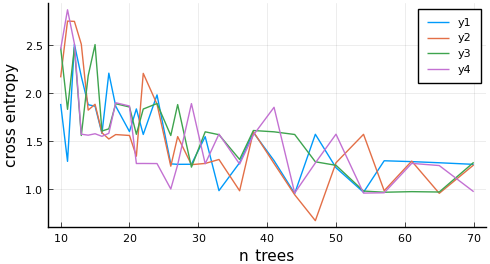

In [130]:
plt = plot()
for i in 1:4
    curve = learning_curve(mach,
                           range=r,
                           resampling=Holdout(),
                           measure=cross_entropy)
    plt=plot!(curve.parameter_values, curve.measurements)
end
xlabel!(plt, "n_trees")
ylabel!(plt, "cross entropy")
plt

6(c)(ii)

In [131]:
evaluate!(mach, resampling=CV(nfolds=9),
                measure=cross_entropy,
                rows=train).measurement[1]

model.n_trees = 90

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/resampling.jl:336
Evaluating over 9 folds: 100%[=========================] Time: 0:00:00


90

6(c)(iii)

In [132]:
err_forest = evaluate!(mach, resampling=Holdout(),
                       measure=cross_entropy).measurement[1]

0.9807594210473173

#### Exercise 7

(a)

In [133]:
@load KMeans pkg=Clustering
@load EvoTreeClassifier
pipe = @pipeline(Standardizer,
                 ContinuousEncoder,
                 KMeans(k=10),
                 EvoTreeClassifier(nrounds=50))

Pipeline1409(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    k_means = KMeans(
            k = 10,
            metric = Distances.SqEuclidean(0.0)),
    evo_tree_classifier = EvoTreeClassifier(
            loss = EvoTrees.Softmax(),
            nrounds = 50,
            λ = 0.0f0,
            γ = 0.0f0,
            η = 0.1f0,
            max_depth = 5,
            min_weight = 1.0f0,
            rowsample = 1.0f0,
            colsample = 1.0f0,
            nbins = 64,
            α = 0.5f0,
            metric = :mlogloss,
            seed = 444)) @903

(b)

In [134]:
mach = machine(pipe, X, y)
evaluate!(mach, resampling=CV(nfolds=6), measure=cross_entropy)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────────┬───────────────┬─────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                      │
├───────────────┼───────────────┼─────────────────────────────────────────────────┤
│ cross_entropy │ 0.827         │ Float32[0.82, 1.06, 0.723, 0.739, 0.899, 0.722] │
└───────────────┴───────────────┴─────────────────────────────────────────────────┘
_.per_observation = [[[3.54, 1.13, ..., 0.128], [0.0627, 0.091, ..., 2.68], [0.0585, 1.39, ..., 0.149], [0.22, 1.09, ..., 1.38], [0.113, 0.831, ..., 0.141], [1.92, 0.114, ..., 0.236]]]


(c)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @997.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/oLVRR/src/tuned_models.jl:474
Evaluating over 10 metamodels: 100%[=========================] Time: 0:00:06


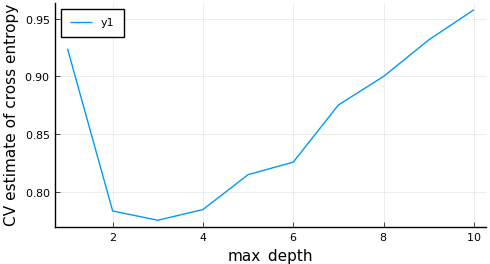

In [135]:
r = range(pipe, :(evo_tree_classifier.max_depth), lower=1, upper=10)

curve = learning_curve(mach,
                       range=r,
                       resampling=CV(nfolds=6),
                       measure=cross_entropy)

plt = plot(curve.parameter_values, curve.measurements)
xlabel!(plt, "max_depth")
ylabel!(plt, "CV estimate of cross entropy")
plt

Here's a second curve using a different random seed for the booster:

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @615.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/oLVRR/src/tuned_models.jl:474
Evaluating over 10 metamodels: 100%[=========================] Time: 0:00:06


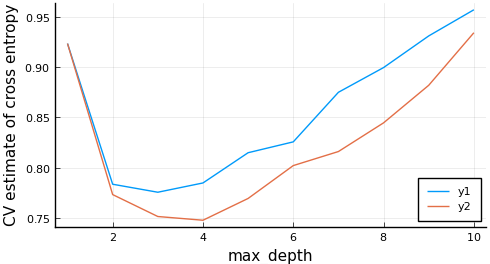

In [136]:
pipe.evo_tree_classifier.seed = 123
curve = learning_curve(mach,
                       range=r,
                       resampling=CV(nfolds=6),
                       measure=cross_entropy)
plot!(curve.parameter_values, curve.measurements)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*